# Demo: NAS with graph morphisms

In [23]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import time
from torchviz import make_dot
import os

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

## Set_up parameters and train/test functions

In [3]:
INPUT_SIZE = 32
INPUT_CHN = 3

N_CLASS = 10
N_EPOCH_TRAIN = 5

BATCH_SIZE = 100
LEARNING_RATE = 1e-4

CIFAR_NAMES = ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

In [4]:
class Cutout(object):
    def __init__(self,patch_size=16,channel_proba=1.0, default_values = [.5,.5,.5]):
        self.patch_size=patch_size
        self.channel_proba = channel_proba
        self.default_values = default_values
    def __call__(self,img):
        npimg = np.array(img)
        h,w,c = npimg.shape
        w1 = np.random.choice(w+self.patch_size-1) - self.patch_size + 1
        w2 = w1 + self.patch_size
        w1 = np.maximum(w1,0)
        w2 = np.minimum(w2,w)

        h1 = np.random.choice(h+self.patch_size-1) - self.patch_size + 1
        h2 = h1 + self.patch_size
        h1 = np.maximum(h1,0)
        h2 = np.minimum(h2,h)

        for channel,val in enumerate(self.default_values):
            if np.random.rand()<=self.channel_proba :
                npimg[h1:h2, w1:w2, channel]=val        

        img = transforms.functional.to_pil_image(npimg)
        return img

In [5]:
# Data Loader (Input Pipeline)
train_transforms = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    Cutout(patch_size=16, default_values=[127., 124., 115.]),
                    transforms.ToTensor()])

# CIFAR Dataset
train_dataset = datasets.CIFAR10(root='./cifar_data/', train=True, transform=train_transforms, download=True)
test_dataset = datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms.ToTensor(), download=False)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [29]:
def train_net(net, optimizer, n_epoch=10, criterion=F.cross_entropy, display_interval=100,
             verbose=3):
    net.train(True)
    
    print("Training...")
    t0 = time.time()
    t00 = t0
    optimizer.zero_grad()

    for epoch in range(n_epoch):
        cumul_loss = 0.0
        running_loss = 0.0
        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.cuda()
            y = y.cuda()

            y_pred = net(X)

            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            cumul_loss += loss.item()

            batch_idx += 1
            if batch_idx % display_interval == 0:
                running_loss /= display_interval
                t1 = time.time()
                if verbose >=3:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tt={:.1f}s'.format(
                        epoch, batch_idx * len(X), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), running_loss, t1-t0))
                running_loss = 0

        cumul_loss /= batch_idx
        t1 = time.time()
        if verbose>=2:
            print('====> Epoch: {} done in {:.1f}s, Average loss: {:.4f}'.format(
                epoch, t1-t0, cumul_loss))
        t0 = t1
    if verbose>=1:
        print('Training done, {} epochs in {:.1f}s, loss at last epoch: {:.4f}'.format(
            n_epoch, t1-t00, cumul_loss))

In [30]:
def test_net(net, use_train=False, criterion=F.cross_entropy, proba_extractor = lambda x:x):
    net.eval()

    if use_train:
        print("Evaluate net on TRAIN:")
        dataloader = train_loader
    else:
        print("Evaluate net on TEST:")
        dataloader = test_loader
    n_in_dataset = len(dataloader.dataset)
    
    cumul_loss = 0.0
    class_ok = 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.cuda()
            ground_truth = y.numpy()
            y = y.cuda()

            net_output = net(X)
            cumul_loss += criterion(net_output, y).item()
            
            y_soft = proba_extractor(net_output)
            _, y_hard = y_soft.max(1)

            prediction = y_hard.cpu().numpy()
            class_ok += np.sum(ground_truth == prediction)

    cumul_loss /= batch_idx+1
    accuracy = class_ok / n_in_dataset
    print("Well classified %5d / %5d, (%5.2f%% accuracy)" % (
        class_ok, n_in_dataset, 100*accuracy))
    print("Average loss : %f" % cumul_loss)
    return cumul_loss, accuracy

## Sample test
Just train a simple network to check that `train_net` and `test_net` work as expected, and get a baseline for what level of accuracy can be expected

In [8]:
image = np.zeros(( (32+2)*10-2, (32+2)*10-2, 3))
img_labels=[]
for ii in range(10):
    for jj in range(10):
        a = ii*(32+2)
        b = jj*(32+2)
        data=train_dataset[jj+10*ii]
        image[a:a+32, b:b+32,:] = np.transpose(data[0].numpy(),(1,2,0))
        img_labels.append((a,b,CIFAR_NAMES[data[1]]))


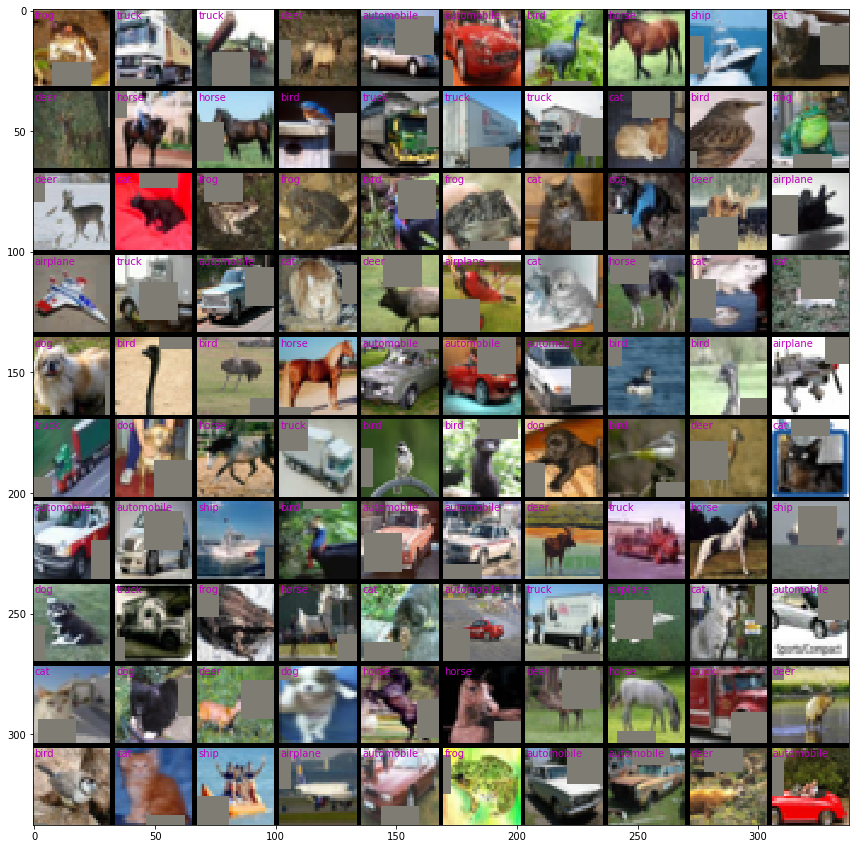

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(image);
for a,b,img_label in img_labels:
    plt.text(b,a,img_label,color='m',va="top")

In [14]:
net01 = nn.Sequential(nn.BatchNorm2d(3),
                    nn.Conv2d(3, 64, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, (5, 5), bias=True, padding=2, padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    # Downsample to 16x16
                    nn.BatchNorm2d(64), 
                    nn.Conv2d(64, 128, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(128, 128, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),
                    # Downsample to 8x8
                    nn.BatchNorm2d(128), 
                    nn.Conv2d(128, 256, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.Conv2d(256, 256, (3, 3), bias=True, padding=1,
                              padding_mode='replicate'),
                    nn.ReLU(),
                    nn.MaxPool2d(2, stride=2),                    
                    # Downsample to 4x4
                    nn.BatchNorm2d(256),
                    nn.Conv2d(256, 512, (3, 3), bias=True, padding=1,
                    padding_mode='replicate'),                    
                    # Classifier  
                    nn.Flatten(),
                    nn.Linear(512*4*4, 2048),
                    nn.ReLU(),
                    nn.Linear(2048, 10),
                    nn.Softmax(dim=1))
net01.cuda()
optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [15]:
train_net(net01,optimizer, n_epoch=10)

Training...
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.1012	t=11.3s
Train Epoch: 0 [20000/50000 (40%)]	Loss: 2.0399	t=23.1s
Train Epoch: 0 [30000/50000 (60%)]	Loss: 2.0004	t=34.8s
Train Epoch: 0 [40000/50000 (80%)]	Loss: 1.9772	t=46.0s
Train Epoch: 0 [50000/50000 (100%)]	Loss: 1.9429	t=57.3s
====> Epoch: 0 done in 57.3s, Average loss: 2.0123
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.9275	t=11.1s
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.9224	t=22.3s
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.9118	t=33.5s
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.9043	t=45.1s
Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.8974	t=56.7s
====> Epoch: 1 done in 56.7s, Average loss: 1.9127
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.8839	t=12.1s
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.8758	t=23.5s
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.8669	t=34.7s
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.8453	t=46.2s
Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.8603	t=57.8s
====> Epoch: 2 done in 57.8s, Average loss:

In [16]:
test_net(net01, use_train=True)
test_net(net01, use_train=False)


Evaluate net on TRAIN:
Well classified 35433 / 50000, (70.87% accuracy)
Average loss : 1.750857

Evaluate net on TEST:
Well classified  7205 / 10000, (72.05% accuracy)
Average loss : 1.739220


(1.7392201817035675, 0.7205)

## Morphism turner
This is done with a variant of NNI Morphism tuner toolbox, which already almost contains everything needed.

It implements a class to represent a Neural Network as a graph and function-preserving morphisms to alter the graph without altering the classification results.

The Bayesian optimizer is replaced by a simple hill climbing algorithm (as in [Elsken 2017](https://arxiv.org/pdf/1711.04528.pdf)) where the most accurate model on test set is repeatedely evolved into a generation of candidates that are trained for a few epochs (giving at each generation a new best candidate).

NNI toolbox natively saves only the model architectures without the weights. This defeats the purpose of *graph morphisms*, which is to speed-up training by re-using the weights. The `graph` and `graph_transform` packages of the toolbox, however, contain everything needed to morph graphs with weights properly handled. Some methods of the tuner are overloaded to allow network weights to be saved as a *.torch* file that goes along with the *json* file that describes the architecture.

**Caveat:** The code below uses the CIFAR10 train set with cutout and random horizontal flips to train the neural networks. Models are evaluated on the CIFAR10 test set and selected according to their average loss or accuracy on this dataset. There is thus a part of the process where the model is fitted to the test set. Models may have poor generalization properties due to overfitting. TODO: the original train set should be split into a training set and a cross-validation set, with the training set used to fit the models and the cross-validation set used to evaluate their accuracy and select the best as father of the next generation. Thus, final evaluation on the test set will be a fair evaluation of the model, with data never used at any  point in the search process.

In [31]:
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner
from nni.networkmorphism_tuner.graph import graph_to_json, json_to_graph


In [32]:
from copy import deepcopy

from nni.utils import OptimizeMode
from nni.networkmorphism_tuner.graph_transformer import transform
from nni.networkmorphism_tuner.utils import Constant
from nni.networkmorphism_tuner.bayesian import SearchTree, edit_distance, contain
from nni.networkmorphism_tuner.networkmorphism_tuner import NetworkMorphismTuner


class HillClimbingOptimizer:
    """ A Bayesian optimizer for neural architectures.
    Attributes:
        gen_size
    """

    def __init__(self, tuner, gen_size=8):
        Constant.N_NEIGHBOURS = gen_size*2
        self.gen_size = gen_size
        self.searcher = tuner
        self.search_tree = SearchTree()
        self.generation_queue = []

    def fit(self, x_queue, y_queue):
        pass

    def generate(self, descriptors):
        """Generate new architecture.
        Args:
            descriptors: All the searched neural architectures.
        Returns:
            graph: An instance of Graph. A morphed neural network with weights.
            father_id: The father node ID in the search tree.
        """
        new_queue = []
        for _ in range(3):
            if new_queue:
                break

            father_id = self.searcher.get_best_model_id()
            graph = self.searcher.load_model_by_id(father_id, load_weights=True)
                
            for temp_graph in transform(graph):
                if contain(descriptors, temp_graph.extract_descriptor()):
                    continue
                descriptors.append(temp_graph.extract_descriptor())
                new_queue.append(temp_graph)
            new_queue = new_queue[:self.gen_size]
            
        if not new_queue:
            return None, None
        else:
            return new_queue, father_id

    def add_child(self, father_id, model_id):
        ''' add child to the search tree
        Arguments:
            father_id {int} -- father id
            model_id {int} -- model id
        '''

        self.search_tree.add_child(father_id, model_id)


class HillClimbingTuner(NetworkMorphismTuner):
    '''Overwrite the Bayesian optimizer in NetworkMorphismTuner
       with the Hill Climbing algorithm
    '''
    def __init__(self, **kwargs):
        gen_size = kwargs.pop("gen_size", 8)
        super(HillClimbingTuner, self).__init__(**kwargs)
        self.bo = HillClimbingOptimizer(self, gen_size)
        
    def generate_parameters(self, parameter_id, **kwargs):
        """
        Returns a set of trial neural architecture, as a serializable object.
        Parameters
        ----------
        parameter_id : int
        """
        if not self.history:
            self.init_search()

        new_father_id = None
        generated_graph = None
        if not self.training_queue:
            new_father_id, graph_list = self.generate()
            if type(graph_list) is not list:
                graph_list = [graph_list]
            for generated_graph in graph_list:
                new_model_id = self.model_count
                self.model_count += 1
                self.training_queue.append(
                    (generated_graph, new_father_id, new_model_id))
                self.descriptors.append(generated_graph.extract_descriptor())

        graph, father_id, model_id = self.training_queue.pop(0)

        # from graph to json
        json_out = self.save_weighted_graph(graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

        return graph

    def load_model_by_id(self,father_id, load_weights=False):
        """Overload to work with weights"""
        graph = super(HillClimbingTuner,self).load_model_by_id(father_id)

        if load_weights and graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            state_dict = torch.load(weight_path)
            model = graph.produce_torch_model()
            model.load_state_dict(state_dict)
            model.set_weight_to_graph()
            graph = model.graph
        return graph
    
    def update_from_model(self,model,parameter_id):
        _, father_id, model_id = self.total_data[parameter_id]
        json_out = self.save_weighted_graph(model.graph, model_id)
        self.total_data[parameter_id] = (json_out, father_id, model_id)

    def save_weighted_graph(self,graph, model_id):
        json_model_path = os.path.join(self.path, str(model_id) + ".json")
        json_out = graph_to_json(graph, json_model_path)
        if graph.weighted:
            weight_path = os.path.join(self.path, str(father_id) + ".torch")
            model = graph.produce_torch_model()
            state_dict = model.state_dict()
            torch.save(state_dict,weight_path)
        return json_out
    
    def receive_trial_result(self, parameter_id, value, model=None, **kwargs):
        if model is not None:
            self.update_from_model(model,parameter_id)
        super(HillClimbingTuner,self).receive_trial_result(parameter_id, None, value, **kwargs)

Use the tuner to minimise the loss function (maximizing accuracy is another option)

In [33]:
tuner = HillClimbingTuner(
    task = "cv",
    input_width = INPUT_SIZE,
    input_channel = INPUT_CHN,
    n_output_node = N_CLASS,
    optimize_mode = "minimize",
    path = "test01_model_path",
    gen_size = 8)

In [34]:
model_nb = 0
gen_id = 0
n_iter = 0
timing=[]
losses=[]
accuracies=[]
parameters=[]

if os.path.isdir(tuner.path):
    filesToRemove = [os.path.join(tuner.path,f) for f in os.listdir(tuner.path)]
    for f in filesToRemove:
        os.remove(f) 

In [35]:
t00 = time.time()
t0 = t00
while gen_id < 8 and n_iter < 80:
    print("\n=========================")
    parameter_id = "gen%02d_model%d"%(gen_id,model_nb)
    print("Iteration %d - %s - %ds elapsed"%(n_iter,parameter_id, t0-t00))
    
    graph = tuner.generate_parameters(parameter_id)
    model = graph.produce_torch_model().cuda()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_net(model, optimizer, n_epoch=N_EPOCH_TRAIN, verbose=1)
    loss, accuracy = test_net(model)
    model.cpu()
    
    tuner.receive_trial_result(parameter_id, loss, model)  
        
    parameters.append(parameter_id)
    print("Best model so far : %s (%d)"%(parameters[tuner.get_best_model_id()],tuner.get_best_model_id()))
    
    n_iter += 1
    if tuner.training_queue: 
        model_nb += 1
    else:
        gen_id += 1
        model_nb = 0
    
    
    t1=time.time()
    timing.append(t1-t0)
    t0=t1
    losses.append(loss)
    accuracies.append(accuracy)
tt = t1-t00
h = (tt)//3600
m = (tt - 3600*h)//60
s = (tt - 3600*h - 60*m)//1
print("******** DONE ********")
print("Full NAS search done in %dh %dm %ds seconds"%(h,m,s))


Iteration 0 - gen00_model0 - 0s elapsed
Training...
Training done, 5 epochs in 71.9s, loss at last epoch: 1.3156
Evaluate net on TEST:
Well classified  5545 / 10000, (55.45% accuracy)
Average loss : 1.217273
Best model so far : gen00_model0 (0)

Iteration 1 - gen01_model0 - 73s elapsed
Training...
Training done, 5 epochs in 95.8s, loss at last epoch: 1.2844
Evaluate net on TEST:
Well classified  5747 / 10000, (57.47% accuracy)
Average loss : 1.181222
Best model so far : gen01_model0 (1)

Iteration 2 - gen01_model1 - 170s elapsed
Training...
Training done, 5 epochs in 79.4s, loss at last epoch: 1.3456
Evaluate net on TEST:
Well classified  5483 / 10000, (54.83% accuracy)
Average loss : 1.239476
Best model so far : gen01_model0 (1)

Iteration 3 - gen01_model2 - 251s elapsed
Training...
Training done, 5 epochs in 79.2s, loss at last epoch: 1.3489
Evaluate net on TEST:
Well classified  5551 / 10000, (55.51% accuracy)
Average loss : 1.231723
Best model so far : gen01_model0 (1)

Iteration 

Training done, 5 epochs in 128.8s, loss at last epoch: 1.0902
Evaluate net on TEST:
Well classified  6458 / 10000, (64.58% accuracy)
Average loss : 0.986066
Best model so far : gen04_model1 (26)

Iteration 31 - gen04_model6 - 3468s elapsed
Training...
Training done, 5 epochs in 130.8s, loss at last epoch: 1.0336
Evaluate net on TEST:
Well classified  6661 / 10000, (66.61% accuracy)
Average loss : 0.916434
Best model so far : gen04_model1 (26)

Iteration 32 - gen04_model7 - 3601s elapsed
Training...
Training done, 5 epochs in 132.2s, loss at last epoch: 1.0659
Evaluate net on TEST:
Well classified  6343 / 10000, (63.43% accuracy)
Average loss : 1.024688
Best model so far : gen04_model1 (26)

Iteration 33 - gen05_model0 - 3735s elapsed
Training...
Training done, 5 epochs in 133.4s, loss at last epoch: 0.9936
Evaluate net on TEST:
Well classified  6557 / 10000, (65.57% accuracy)
Average loss : 0.977589
Best model so far : gen04_model1 (26)

Iteration 34 - gen05_model1 - 3871s elapsed
Trai

Search done in 7866s


Text(0.5, 0, 'Model ID')

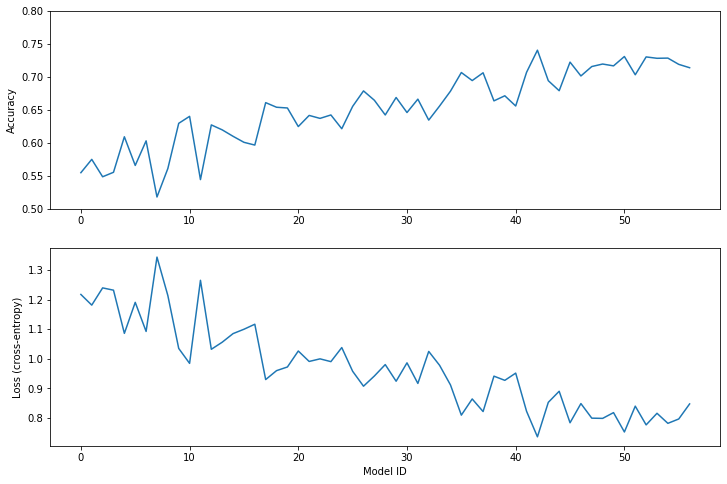

In [44]:
print("Search done in %ds"%sum(timing))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.ylim(.5,.8)

plt.subplot(2,1,2)
plt.plot(losses);
plt.ylabel("Loss (cross-entropy)")
plt.xlabel("Model ID")

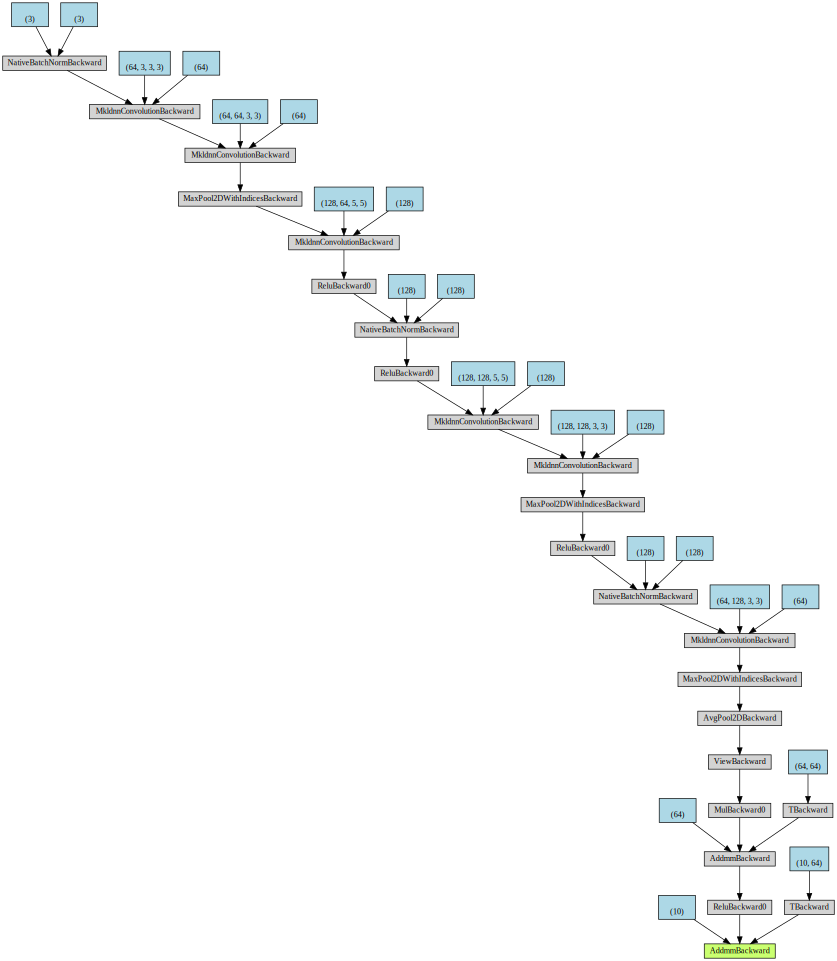

In [37]:
best_graph = tuner.load_best_model()
best_model = best_graph.produce_torch_model()

x,y = test_dataset[0]
x.unsqueeze_(0)
make_dot(best_model(x))

In [40]:
arr_timing = np.array(timing)
arr_losses = np.array(losses)
arr_accuracies = np.array(accuracies)
arr_path = os.path.join(tuner.path, "metrics.npz")
np.savez(arr_path, timing=arr_timing,
        losses=arr_losses, accuracies=arr_accuracies)